In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy


In [2]:
def fetch_image(data_folder):
    train_data = []
    test_data = []
    valid_data = []

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load and preprocess the image
            imgTrafficSignal = Image.open(image_path)
            imgTrafficSignal = imgTrafficSignal.convert("L")  # Convert to grayscale
            img_width, img_height = imgTrafficSignal.size

            with open(label_path, "r") as label_file:
                label_lines = label_file.readlines()
                for line in label_lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert normalized bounding box to pixel coordinates
                    x_center_pixel = int(x_center * img_width)
                    y_center_pixel = int(y_center * img_height)
                    width_pixel = int(width * img_width)
                    height_pixel = int(height * img_height)

                    # Calculate the bounding box corners
                    x1 = max(x_center_pixel - width_pixel // 2, 0)
                    y1 = max(y_center_pixel - height_pixel // 2, 0)
                    x2 = min(x_center_pixel + width_pixel // 2, img_width)
                    y2 = min(y_center_pixel + height_pixel // 2, img_height)

                    # Crop the sign area from the image
                    cropped_img = imgTrafficSignal.crop((x1, y1, x2, y2))
                    cropped_img = cropped_img.resize((90, 90))  # Resize to 90x90

                    # Append the cropped image and class ID to the appropriate dataset
                    if split_name == "train":
                        train_data.append((np.array(cropped_img), class_id))
                    elif split_name == "test":
                        test_data.append((np.array(cropped_img), class_id))
                    elif split_name == "valid":
                        valid_data.append((np.array(cropped_img), class_id))

    return train_data, test_data, valid_data

In [3]:
# Example usage
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image(data_folder)

In [4]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features)
training_data_labels = np.array(training_data_labels)

# Normalize the images
# Normalize the images to 0-1
training_data_features = training_data_features.astype(np.float32) / 255.0

# Reshape for CNN (add channel dimension)
training_data_features = training_data_features.reshape(-1, 90, 90, 1)

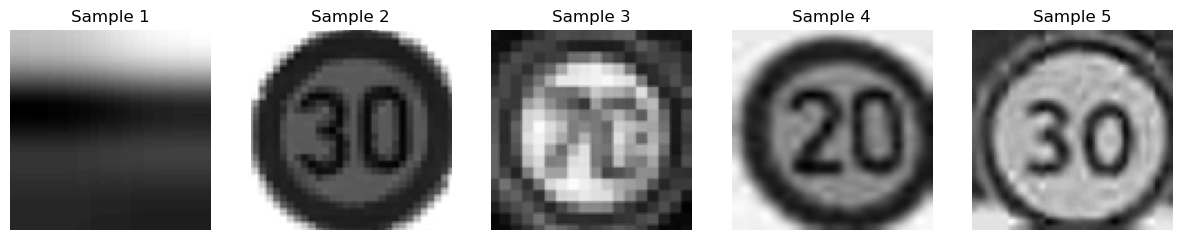

In [5]:
import matplotlib.pyplot as plt
import random

fig, axs = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    random_idx = random.randint(0, len(training_data_features) - 1)
    img = training_data_features[random_idx]

    # Ensure proper scaling to 0-255
    img = (img * 255).astype(np.uint8)

    axs[i].imshow(img, cmap="gray")
    axs[i].axis("off")
    axs[i].set_title(f"Sample {i+1}")

plt.show()


In [6]:
training_data_labels

array([ 7,  7,  7, ..., 14, 14, 14])

In [7]:
cnnModel = Sequential()
cnnModel.add(Conv2D(16,(3,3), padding="same", input_shape=(90, 90, 1), activation='relu'))
print(cnnModel(training_data_features).shape)
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(32,(3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(64,(5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Conv2D(128,(7,7), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))
cnnModel.add(Flatten())
cnnModel.add(Dense(232, activation='relu'))
cnnModel.add(Dense(116, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


(4298, 90, 90, 16)


In [8]:
cnnModel.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 90, 90, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 45, 45, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 45, 45, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 23, 23, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 23, 23, 64)          │          51,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 12, 12, 128)         │         401,536 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 6, 6, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 4608)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 232)                 │       1,069,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 116)                 │          27,028 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 15)                  │           1,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,555,671 (5.93 MB)

 Trainable params: 1,555,671 (5.93 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])


In [10]:
# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features)
validation_data_labels = np.array(validation_data_labels)

# Normalize validation images
validation_data_features = validation_data_features / 255.0
validation_data_features = validation_data_features.reshape(-1, 90, 90, 1)

# Train the model
trafficSignNetwork = cnnModel.fit(
    training_data_features, 
    training_data_labels, 
    validation_data=(validation_data_features, validation_data_labels),
    epochs=10, 
    batch_size=32
)

Epoch 1/10


C:\Users\manou\AppData\Roaming\Python\Python312\site-packages\keras\src\backend\tensorflow\nn.py:678: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


135/135 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.1776 - loss: 2.4816 - val_accuracy: 0.4333 - val_loss: 1.6820
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.4846 - loss: 1.5278 - val_accuracy: 0.7712 - val_loss: 0.7242
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.7859 - loss: 0.6791 - val_accuracy: 0.8633 - val_loss: 0.4872
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.8859 - loss: 0.3594 - val_accuracy: 0.9068 - val_loss: 0.3158
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.9111 - loss: 0.2587 - val_accuracy: 0.9206 - val_loss: 0.2869
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9361 - loss: 0.1942 - val_accuracy: 0.9131 - val_loss: 0.3284
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9458 - loss: 0.1579 - val_accuracy: 0.8962 - val_loss: 0.3695
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - accuracy: 0.9534 - loss: 0.1439 - val_accuracy: 

<Axes: >

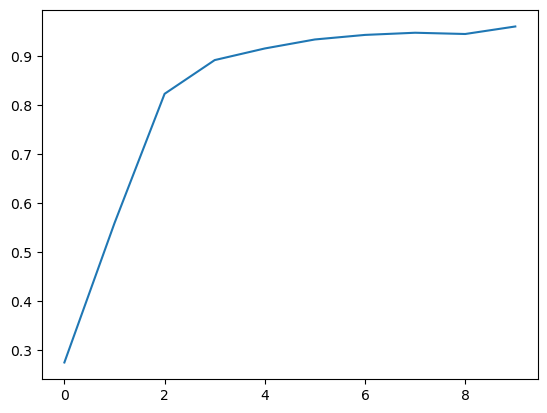

In [11]:
import seaborn as sns
sns.lineplot(trafficSignNetwork.history['accuracy'])


In [12]:
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features)
test_data_labels = np.array(test_data_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


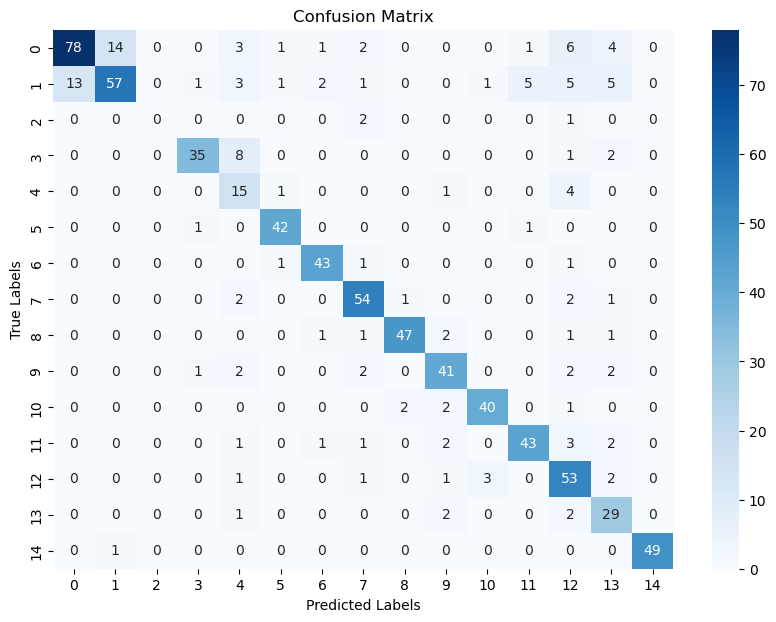

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 78
False Positive (FP): 13
False Negative (FN): 32
True Negative (TN): 647
Precision: 0.8571
Recall: 0.7091
F1-Score: 0.7761
Accuracy: 0.9416

Class 1:
True Positive (TP): 57
False Positive (FP): 15
False Negative (FN): 37
True Negative (TN): 661
Precision: 0.7917
Recall: 0.6064
F1-Score: 0.6867
Accuracy: 0.9325

Class 2:
True Positive (TP): 0
False Positive (FP): 0
False Negative (FN): 3
True Negative (TN): 767
Precision: 0.0000
Recall: 0.0000
F1-Score: 0.0000
Accuracy: 0.9961

Class 3:
True Positive (TP): 35
False Positive (FP): 3
False Negative (FN): 11
True Negative (TN): 721
Precision: 0.9211
Recall: 0.7609
F1-Score: 0.8333
Accuracy: 0.9818

Class 4:
True Positive (TP): 15
False Positive (FP): 21
False Negative (FN): 6
True Negative (TN): 728
Precision: 0.4167
Recall: 0.7143
F1-Score: 0.5263
Accuracy: 0.9649

Class 5:
True Positive (TP): 42
False Positive (FP): 4
False Negative (FN): 2
True Negative (TN): 722
Precision: 0.9130
Recall: 0.9545
F1-Score: 

In [15]:
cnnModel.save("modelb.h5")


In [16]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.86      0.71      0.78       110
           1       0.79      0.61      0.69        94
           2       0.00      0.00      0.00         3
           3       0.92      0.76      0.83        46
           4       0.42      0.71      0.53        21
           5       0.91      0.95      0.93        44
           6       0.90      0.93      0.91        46
           7       0.83      0.90      0.86        60
           8       0.94      0.89      0.91        53
           9       0.80      0.82      0.81        50
          10       0.91      0.89      0.90        45
          11       0.86      0.81      0.83        53
          12       0.65      0.87      0.74        61
          13       0.60      0.85      0.71        34
          14       1.00      0.98      0.99        50

    accuracy                           0.81       770
   macro avg       0.76      0.78      0.76       770
weighted avg       0.83   

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
